<font size="5">**Прогнозирование оттока клиентов фитнес центра\
     с использованием ML**</font>\
Customer Churn Prediction for a Fitness Center

# Описание проекта

**Цель**\
Прогнозирование возможного оттока клиентов для фитнес центра.\
Подготовка план действий по удержанию клиентов.

**Задачи**
- Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их;
- Проанализировать основные признаки, наиболее сильно влияющие на отток;
  Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

**План**
- Изучение имеющихся данных и их предобработка;
- Анализ статистики метрик датасета, распределений и корреляций;
- Построение модели прогнозирования оттока клиентов;
- Кластеризация клиентов;
- Формулирование выводов и рекомендаций по работе с клиентами.

**Исходные данные**\
Датасет, содержащий оцифрованные данные из 4000 анкет клиентов.

<div style="background-color: #99FFFF; padding: 10px;">

# Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import numpy as np
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import itertools
from scipy.cluster.hierarchy import dendrogram, linkage

# для проверки количества кластеров по линии раздела в дендрограмме
from scipy.cluster.hierarchy import fcluster

# отображение вывода в той же ячейке
%matplotlib inline

# глобальный формат для десятичных дробей 
pd.options.display.float_format = '{:.3f}'.format

In [2]:
try:
    gym_churn_raw = pd.read_csv('gym_churn.csv')
except:
    gym_churn_raw = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
# смотрим исходный датасет
display (gym_churn_raw.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227,5.000,3,0.020,0.000,0
1,0,1,0,0,1,12,1,31,113.203,12.000,7,1.923,1.910,0
2,0,1,1,0,1,1,0,28,129.448,1.000,2,1.859,1.737,0
3,0,1,1,1,1,12,1,33,62.670,12.000,2,3.206,3.357,0
4,1,1,1,1,1,1,0,26,198.362,1.000,3,1.114,1.120,0


# Предварительный анализ данных и предобработка

## Предварительный анализ

In [4]:
# Смотрим состав данных
gym_churn_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
# Проверяем наличие полных дубликатов
duplicated_gym_churn_raw = gym_churn_raw.duplicated().sum()
display(f"Количество полных дубликатов в таблице: {duplicated_gym_churn_raw}")

'Количество полных дубликатов в таблице: 0'

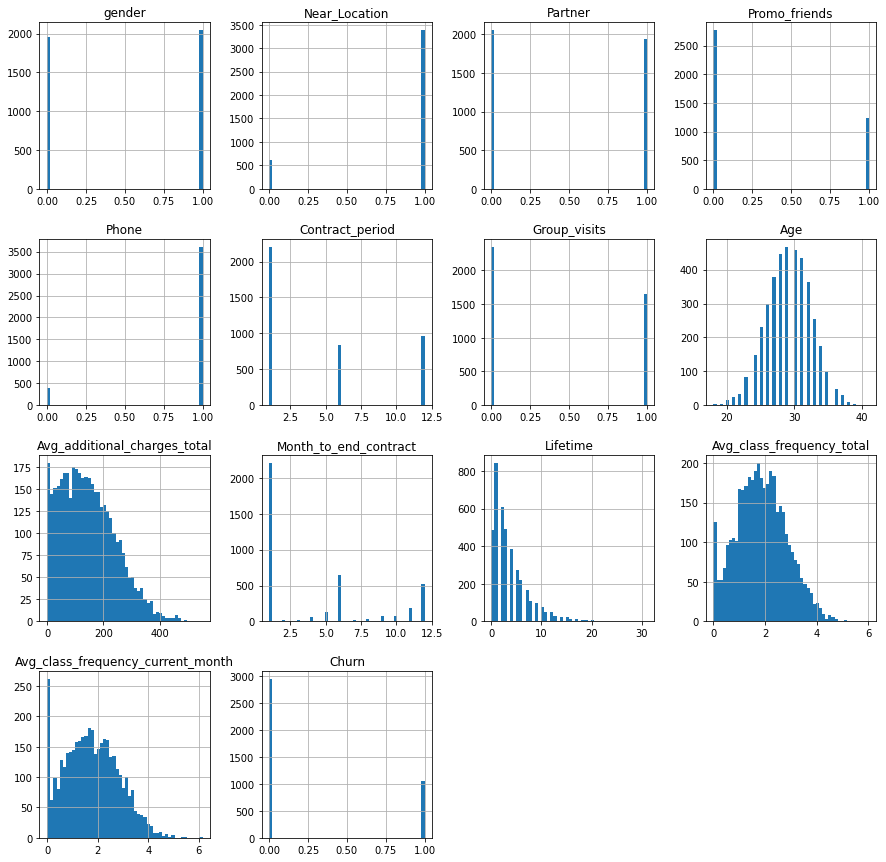

In [6]:
gym_churn_raw.hist(bins=50, figsize=(15, 15))
plt.show()

In [7]:
print (f"Количество наблюдений по группам оттока = {gym_churn_raw['Churn'].value_counts()}")

Количество наблюдений по группам оттока = 0    2939
1    1061
Name: Churn, dtype: int64


**Наблюдения**
- Пропущенных значений и строк-дубликатов в датасете нет;
- Все параметры имеют адекватные, числовые, форматы - int или float;
- Группы клиентов по признаку оттока не равны между собой;
- Гистограммы в целом не вызывают вопросов, кроме Avg_class_frequency_current_month, имеющая пик в районе нуля.
  Этот пик - результат влияния группы клиентов, ни разу не посетивших центр за предыдущий месяц.

## Предобработка

Приведём наименования столбцов в более удобный вид.

In [8]:
# Делаем копию исходного датасета для дальнейшей работы
gym_churn = gym_churn_raw.copy()

In [9]:
# Приводим названия столбцов в более удобный вид
gym_churn.columns = gym_churn.columns.str.lower()

**Результат предобработки**
- Исправлены наименования столбцов.

<div style="background-color: #99FFFF; padding: 10px;">

# Исследовательский анализ данных (EDA)

## Статискика датасета

In [10]:
print (f"Количество наблюдений по группам оттока = {gym_churn['churn'].value_counts()}")

Количество наблюдений по группам оттока = 0    2939
1    1061
Name: churn, dtype: int64


**Наблюдение**\
Группа клиентов, попавшая в отток, составляет почти 30 процентов датасета.

**Выведем статистические показатели**

In [11]:
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000
mean,0.510,0.845,0.487,0.308,0.903,4.681,0.412,29.184,146.944,4.323,3.725,1.879,1.767,0.265
std,0.500,0.362,0.500,0.462,0.295,4.550,0.492,3.258,96.356,4.191,3.749,0.972,1.053,0.442
min,0.000,0.000,0.000,0.000,0.000,1.000,0.000,18.000,0.148,1.000,0.000,0.000,0.000,0.000
25%,0.000,1.000,0.000,0.000,1.000,1.000,0.000,27.000,68.869,1.000,1.000,1.181,0.963,0.000
50%,1.000,1.000,0.000,0.000,1.000,1.000,0.000,29.000,136.220,1.000,3.000,1.833,1.720,0.000
75%,1.000,1.000,1.000,1.000,1.000,6.000,1.000,31.000,210.950,6.000,5.000,2.536,2.510,1.000
max,1.000,1.000,1.000,1.000,1.000,12.000,1.000,41.000,552.591,12.000,31.000,6.024,6.147,1.000


**Наблюдения**\
Бинарные признаки:\
Среднее значение и стандартное отклонение говорят о смещении значений в ту или другую сторону. Чем ближе среднее значение и стандартное отклонение к 0,5, тем равномернее распределён параметр.
>Мы видим, что **наиболее равномерно** распределён параметр gender - среднее = 0,51. отклонение 0,5. Мужчины и женщины присутствуют в равной мере.\
>**Наименее равномерно** распределён признак phone - посетителей, оставивших номер телевона - преобладающее большинство.\
> Интересен параметр near_location. Его статистика говорит, что большинство клиентов живут или работают в том же районе, в котором находится фитнес-центр.\
>Среднее значение нашего целевого показателя churn говорит, что отказавшихся от услуг центра меньше, чем продолжающих пользоваться им. Это было видно также из различия в объёме групп.

Непрерывные признаки (некоторые из них):
> Возраст. Среднее значение в районе 29 лет. Отклонение не большое - 3,26 года.\
> lifetime. Среднее - 3,76 месяца при сопоставимом уровне отклонения. lifetime имеет большой разброс, что подтверждается также диапазоном мин-макс - от нуля до 31 месяца.

 Другие параметры будут рассмотрены ниже.


Смотрим средние значения параметров по группам оттока.

In [12]:
# Убираем столбец churn, так как он не нужен в итоговой таблице
columns_to_categories = []  # создаём пустой список
for col in gym_churn.columns:
    if col != 'churn':  # условие внутри тела цикла
        columns_to_categories.append(col)  # добавляем столбец в список

churn_categories = gym_churn.groupby('churn')[columns_to_categories].mean()
display(churn_categories)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510,0.873,0.534,0.354,0.904,5.747,0.464,29.977,158.446,5.283,4.712,2.025,2.028
1,0.511,0.768,0.355,0.184,0.903,1.729,0.269,26.990,115.083,1.663,0.991,1.475,1.045


**Наблюдения**\
Группы попавших в отток и не попавших в отток НЕ различаются или слабо различаются по параметрам:\
  gender, near_location, phone, avg_additional_charges_total, age.
>Имеющиеся разлисия, скорее всего, находятся ниже уровня статистической значимости.\
На пример, по показателю age различие групп  почти 3 года, но и стандартное отклонение этого параметра 3,26.\
*В рамках этого проекта не ставилась цель делать более детальный анализ.*


**Клиенты, попавшие в отток** имеют меньшие показатели\
Длительности коньракта, Частоты посещений, Лайфтайма,\
заключают контракты на меньший срок,\
меньше посещают групповые занятия и в меньшей степени имеют отношение к партнёрским и маркетинговым программам.

## Сравнение групп клиентов, разднлённых по признаку оттока

In [13]:
# Разделяем датасет на 2 группы по признаку churn
churn_group_0 = gym_churn.query('churn == 0')
churn_group_1 = gym_churn.query('churn == 1') 
display(churn_group_0.head(3))
display(churn_group_1.head(3))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227,5.000,3,0.020,0.000,0
1,0,1,0,0,1,12,1,31,113.203,12.000,7,1.923,1.910,0
2,0,1,1,0,1,1,0,28,129.448,1.000,2,1.859,1.737,0


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
7,0,1,0,0,1,1,0,30,217.787,1.000,0,1.214,1.049,1
11,1,1,1,0,1,1,0,27,266.784,1.000,2,2.349,1.584,1
13,1,1,0,0,1,1,1,27,152.749,1.000,1,0.000,0.000,1


Проверяем объёмы групп

In [14]:
print (f'Количество наблюдений в группе churn_group_0 = {churn_group_0.shape[0]}')
print (f'Количество наблюдений в группе churn_group_1 = {churn_group_1.shape[0]}')

Количество наблюдений в группе churn_group_0 = 2939
Количество наблюдений в группе churn_group_1 = 1061


Датасет разделён правильно - количества групп совпадают с полученными ранее другом методом.

Делаем сдвоенный вывод признаков, чтобы сравнить распределение каждого из них в разных группах.

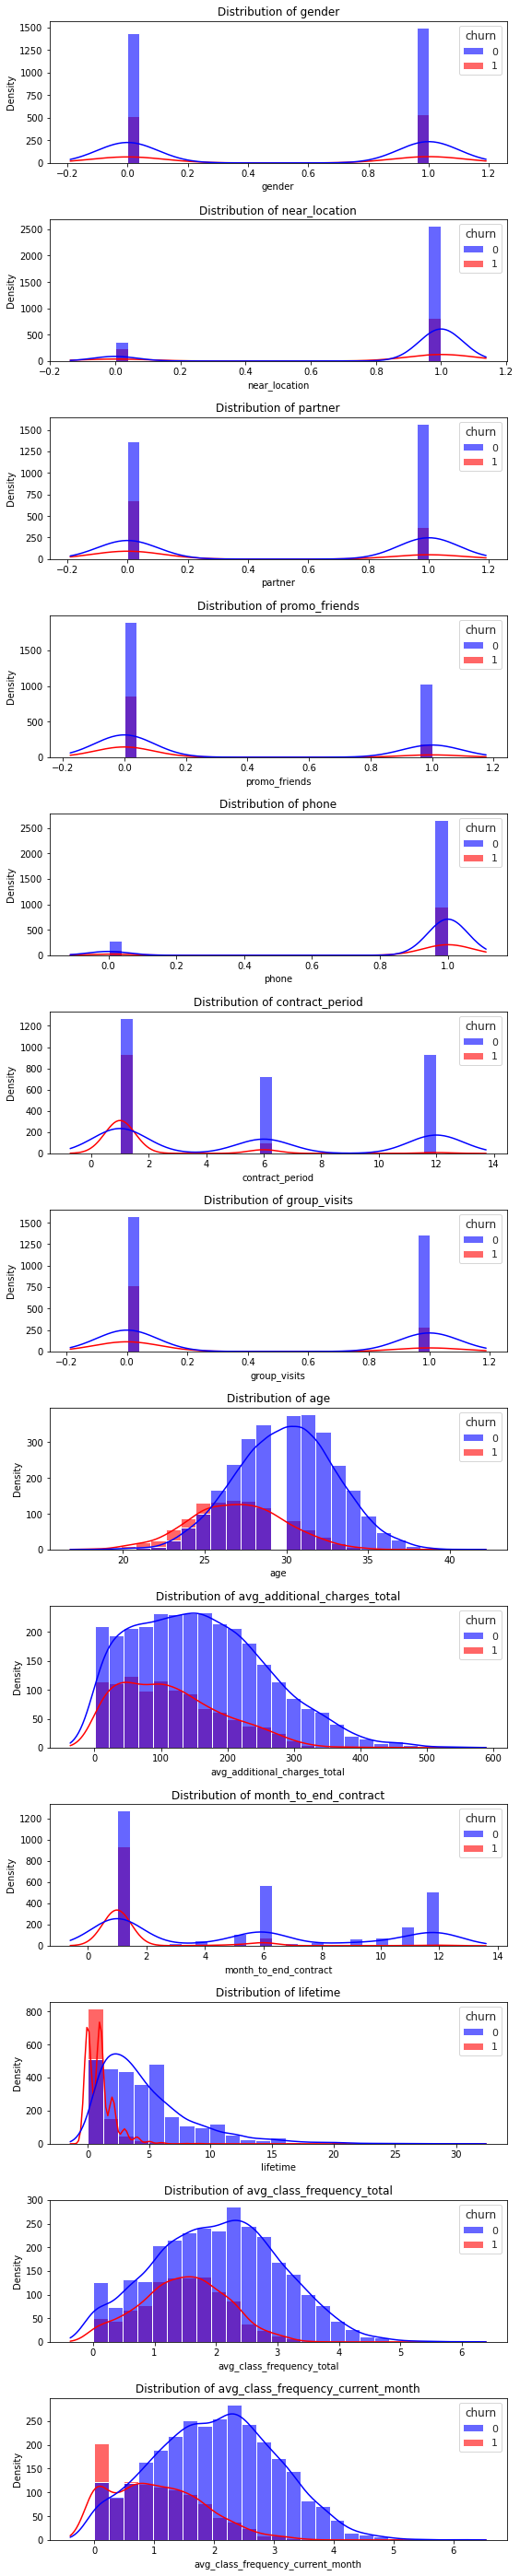

In [15]:
# Список столбцов, кроме 'churn'
columns_to_hist_1 = [col for col in gym_churn.columns if col != 'churn']

# Создаем сетку графиков (по числу признаков)
num_features = len(columns_to_hist_1)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, num_features * 3))

# Задаём стиль, palette=None. (В дальнейшем восстановим белый фон у дендрограмм)
sns.set_theme(style="whitegrid", palette=None)  

# Перебираем все признаки
for idx, col in enumerate(columns_to_hist_1):
    # Объединяем данные в один DataFrame с меткой 'churn'
    data = gym_churn[[col, 'churn']]
    
    # Строим гистограмму с разделением по 'churn'
    sns.histplot(
        data=data, x=col, hue='churn', bins=25, kde=True,ax=axes[idx],
        kde_kws={'bw_adjust': 1, 'cut': 2}, alpha=0.6, 
        palette={1: 'red', 0: 'blue'}
    )
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Density')

# Настраиваем расстояние между графиками
plt.tight_layout()
plt.show() 

**Наблюдения**
- В целом, набор гистограмм иллюстрирует те же различия групп по признаку оттока, о которых мы говорили раньше (см. п. 4.1 "Статистика датасета").\
Это:
  - Группы попавших в отток и не попавших в отток НЕ различаются или слабо различаются по параметрам:\
gender, near_location, phone, avg_additional_charges_total, age.\
Имеющиеся разлисия, скорее всего, находятся ниже уровня статистической значимости.
  - Клиенты, попавшие в отток имеют меньшие показатели Длительности коньракта, Частоты посещений, Лайфтайма. меньше посещают групплвые занятия и в меньшей степени имеют отношение к партнёрским и маркетинговым программам, а также в большей мере заключают короткие контракты в 1 месяц. 
- Добавим:
  - Параметр age имеет идеальную кривую нормального распределения;
  - 'Avg_class_frequency_total' и 'Avg_class_frequency_current_month' имеют близкое к нормальному распределение.
  - Наблюдаются пик в районе нуля у 'Avg_class_frequency_current_month' в группе "churn 1".\
   Это объясняется особенностью группы - часть клиентов, попавших в отток, не пользовались услугами фитнес-центра.
  - Распределения параметров 'Avg_additional_charges_total' и 'Lifetime' имеют форму обрезанного слева нормального распределения. В правой части (значения выше среднего) они приближаются к нормальному распределению.
      

## Матрица корреляций

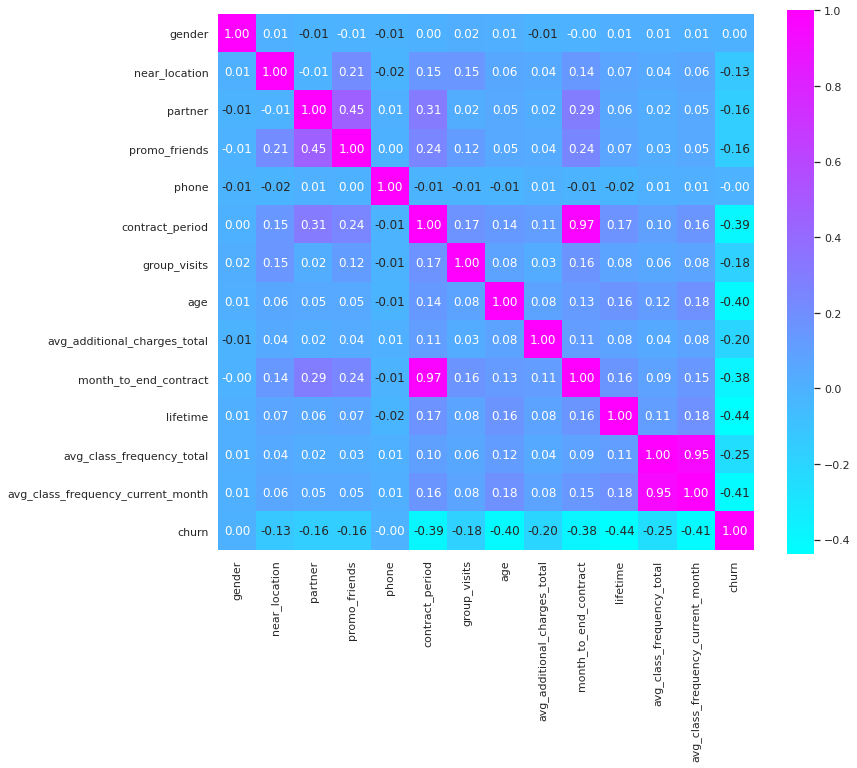

In [16]:
# Оставляем только числовые столбцы
#churn_group_1_numeric = churn_group_1.select_dtypes(include='number')

# Рассчитываем корреляционную матрицу
churn_group_corr = gym_churn.corr()

# Строим тепловую карту
plt.figure(figsize=(12, 10))
sns.heatmap(churn_group_corr, annot=True, cmap='cool', fmt='.2f', square=True)
plt.title('Корреляционная матрица churn_group_1', fontsize=14)
plt.title('')
plt.show()


**Наблюдения**
- Интересующий нас параметр churn имеет отрицательную корреляцию со всеми параметрами, кроме gendr.\
  Это значит, что увеличение значений этих признаков связано с уменьшением оттока.\
  С параметром gendr корреляция отсутствует, что может говорить также о более опосредованной, не прямой, связи с оттоком.
- Присутствует две пары параметров с высокой корреляцией. Это пара "month_to_end_contract  -- contract_period"\
  и пара "avg_class_frequency_total --	avg_class_frequency_current_month".
> Для проверки моделей сделаем тест - удалим параметры с высокой корреляцией, оставив по одному из пары.\
> И сравним поведение моделей с удалёнными параметрами и с полным набором.

<div style="background-color: #99FFFF; padding: 10px;">

# Модель прогнозирования оттока клиентов

**Проверяем поведение моделей на сокращённом наборе признаков.**\
Удаляем признаки с высокой корреляцией, оставляя по одному из пары.

In [17]:
# Список столбцов для ML. Удаляем признаки, сильно коррелирующие с другими
columns_to_model = [
    col for col in gym_churn.columns if col not in [
        'contract_period', 'avg_class_frequency_current_month']]

gym_churn_to_model= gym_churn[columns_to_model]

In [18]:

# разделим наши данные на признаки (X) и целевую переменную (y)
X = gym_churn_to_model.drop(columns=['churn'])
y = gym_churn_to_model['churn']

# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# применяем стандартизацию к матрице признаков для тренировочной выборки
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# задайте список моделей
models = [
    RandomForestClassifier(n_estimators=100, random_state=0),
    LogisticRegression( random_state=0),
         ]

# функция, которая принимает на вход модель и данные и выводит метрики классификации
def make_prediction(m, X_train, y_train, X_test, y_test):
    m.fit(X_train, y_train)  # обучаем модель
    y_pred = m.predict(X_test)  # делаем прогноз на тестовых данных
    acc = accuracy_score(y_test, y_pred)  # считаем Accuracy
    precision = precision_score(y_test, y_pred)  # считаем Precision
    recall = recall_score(y_test, y_pred)  # считаем Recall
    f1 = f1_score(y_test, y_pred)  # считаем F1
    print('Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} F1:{:.2f}'.format(acc, precision, recall, f1))

# цикл для вывода метрик по всем моделям
for model in models:
    print(f'\nМодель: {model.__class__.__name__}')
    make_prediction(model, X_train_st, y_train, X_test_st, y_test)
print()


Модель: RandomForestClassifier
Accuracy:0.89 Precision:0.80 Recall:0.78 F1:0.79

Модель: LogisticRegression
Accuracy:0.90 Precision:0.80 Recall:0.83 F1:0.81



**Проверяем поведение моделей на полном наборе данных.**

In [19]:
# делим данные на признаки (X) и целевую переменную (y)
X = gym_churn.drop(columns=['churn'])
y = gym_churn['churn']

# делимм модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# обучаем scaler и трансформируем матрицу для обучающей выборки
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# задайте список моделей
models = [
    RandomForestClassifier(n_estimators=100, random_state=0),
    LogisticRegression( random_state=0),
         ]
# функция, которая принимает на вход модель и данные и выводит метрики классификации
def make_prediction(m, X_train, y_train, X_test, y_test):
    m.fit(X_train, y_train)  # обучаем модель
    y_pred = m.predict(X_test)  # делаем прогноз на тестовых данных
    acc = accuracy_score(y_test, y_pred)  # считаем Accuracy
    precision = precision_score(y_test, y_pred)  # считаем Precision
    recall = recall_score(y_test, y_pred)  # считаем Recall
    f1 = f1_score(y_test, y_pred)  # считаем F1
    print('Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} F1:{:.2f}'.format(acc, precision, recall, f1))

# цикл для вывода метрик по всем моделям
for model in models:
    print(f'\nМодель: {model.__class__.__name__}')
    make_prediction(model, X_train_st, y_train, X_test_st, y_test)



Модель: RandomForestClassifier
Accuracy:0.92 Precision:0.88 Recall:0.79 F1:0.83

Модель: LogisticRegression
Accuracy:0.93 Precision:0.88 Recall:0.83 F1:0.85


**Наблюдения**\
Обе модели лучше работают на полных данных, чем на сокращённых.


Метрики Accuracy (Точность), Precision (Точность положительных прогнозов) и Recall (Полнота) на высоком уровне.\
Метрика F1 score, что модели имеют хороший баланс между Precision и Recall.


Тем не менее,\
**лучший результат даёт модель RandomForestClassifier, работающая на полном объёме данных.**

**Проверми важность признаков, применив модель RandomForestClassifier**.

In [20]:
# финальная модель
final_model = RandomForestClassifier(random_state=0) 
# Обучаем модель ещё раз
final_model.fit(X_train_st, y_train)  

# создадим датафрейм с именами признаков и их важностью
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_model.feature_importances_})

# выведем датафрейм по убыванию важности признаков
sorted_features = feature_importances.sort_values(by ='Importance', ascending=False)
print(sorted_features)

                              Feature  Importance
10                           lifetime       0.266
12  avg_class_frequency_current_month       0.176
11          avg_class_frequency_total       0.137
7                                 age       0.125
8        avg_additional_charges_total       0.089
9               month_to_end_contract       0.075
5                     contract_period       0.064
6                        group_visits       0.017
0                              gender       0.012
2                             partner       0.012
3                       promo_friends       0.010
1                       near_location       0.010
4                               phone       0.006


**Вывод**\
Из протестированных моделей лучший результат даёт модель RandomForestClassifier, работающая с полным набором параметров.
>**Выбранная модель ранжирует данные следующим образом**:\
Наиболее связанные с оттоком клиентов параметры 'lifetime', 'avg_class_frequency_current_month',  'avg_class_frequency_total' и 'age'.\
*При этом, как мы уже видели в матрице, корреляция отрицательная - с ростом этих параметров отток уменьшается.*

<div style="background-color: #99FFFF; padding: 10px;">

# Кластеризация клиентов

## Вариант 1 - кластеризация на основе полного набора признаков

In [21]:
# убираем столбец churn
# Список столбцов, кроме 'churn'
columns_to_clast = [col for col in gym_churn.columns if col != 'churn']

# Создаем датасеты для гистограмм только с нужными столбцами
churn_group_clast = gym_churn[columns_to_clast]
#churn_group_clast

In [22]:
# стандартизируем данные
sc = StandardScaler()
churn_group_clast_st = sc.fit_transform(churn_group_clast)


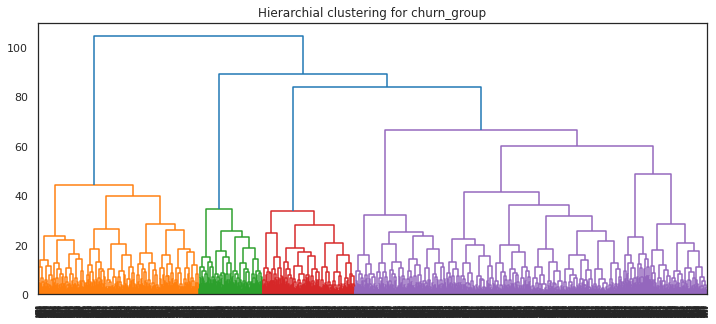

In [23]:
# строим дендрограмму
linked = linkage(churn_group_clast_st, method = 'ward')
linked

with sns.axes_style("white"): #задаём белый фон, так как раньше отменили стили
    plt.figure(figsize=(12, 5))
    dendrogram(linked, orientation='top')
    plt.title('Hierarchial clustering for churn_group')
    plt.show()

**Наблюдение**\
Переход от 3 к 4 кластерам и от 5 к 6 сопровождается незначительными различиями между группами признаков.\
Выбираем уровень разбиения, равный 5 кластерам.\
Посмотрим, помешает ли нам слабое разделение на уровне 3-4.
  

In [24]:
# задаём модель k_means с числом кластеров 5, фиксируем значение random_state,
# задаём количество начальных инициализаций n_init=10

km = KMeans(n_clusters=5, random_state=0, n_init=10)
            
# строим кластеры клиентов
labels = km.fit_predict(churn_group_clast_st)
gym_churn['cluster'] = labels

# выводим средние значения признаков по кластерам и сотритуем таблицу по доле оттока
gym_churn_groupby = gym_churn.groupby('cluster').mean().sort_values(by='churn', ascending = False)
display(gym_churn_groupby)


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
3,0.486,1.000,0.350,0.240,1.000,1.948,0.342,28.168,131.622,1.857,2.441,1.248,1.013,0.514
2,0.495,0.000,0.463,0.079,1.000,2.352,0.216,28.477,135.458,2.198,2.810,1.660,1.477,0.444
1,0.522,0.862,0.470,0.306,0.000,4.787,0.426,29.301,143.958,4.475,3.925,1.847,1.716,0.268
4,0.560,0.976,0.357,0.230,0.999,2.669,0.474,30.125,161.658,2.459,4.899,2.852,2.850,0.068
0,0.503,0.959,0.783,0.574,1.000,10.889,0.543,29.982,160.761,9.954,4.737,1.982,1.975,0.028


In [25]:
# выводим оттельно пары кластер-доля оттока и сортируем по убыванию
cluster_analysis = gym_churn.groupby('cluster').agg(
         {'churn': 'mean'}).sort_values(by='churn', ascending = False
                                                      )
cluster_analysis

,churn
cluster,
3,0.514
2,0.444
1,0.268
4,0.068
0,0.028


**Посмотрим размер кластеров.**

In [26]:
gym_churn['cluster'].value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: cluster, dtype: int64

**Наблюдения**\
Мы получили 5 кластеров.\
Из них номера 3 и 2 имеют наибольшую долю оттока.  Номера 0 и 4 - наименьшую.\
Кластер №1 занимает среднюю позицию, но по доле оттока он третий в группе нестабильных кластеров.


Таким образом 5 кластеров распределились так: 3 нестабильных и 2 стабильных по отношению к оттоку (лояльности).

**Средний по оттоку кластер** (№1) Имеет отличительную особенность - среднее количество оставивших номер телефона равно нулю.\
Другие показатели не дают какого-либо определённого представления о характере кластера - значения могут относиться как к стабильным, так и к нестабильным кластерам.

>Объединение в один кластер клиентов по признаку, имеющему нулевую корреляцию с целевым показателем  (см. матрицу) и тот факт, что ранее, при расчёте средних значений с разбивкой по группам оттока (см. раздел 4.1 "Статистика датасета") мы видели равномерное распределение этого признака по группам оттока - **всё это говорит в пользу иной разбивки на кластеры, чем та, которая только что была сделана**.

В итоге, полученные кластеры не имеют яруо выраженных различий.\

Если крайние кластеры заметно отличаются по всем признакам, связанным с активностью, то средний кластер, хоть он и тяготеет к нестабильным, смазывает картину.


**Возможно, лучщий результат даст ограничение количества признаков. участвующих в кластеризации**.\
Проверим это в следующем разделе.


<div style="background-color: #99FFFF; padding: 10px;">

## Вариант 2 - кластеризация на основе сокращённого набора признаков

Уберём из кластеризации избыточные признаки, которые не несут полезной информации (сильно коррелирующие и неинформативные):
- параметры, имеющие пары с высокой корреляцией - month_to_end_contract и class_frequency_current,
- признак, равномерно аспределённый по группам оотка (такой анализ был сделан выше в разделе 4.1 "Статистика датасета") - gender,
- признак, положительно присутствующий у 90% клиентов - phone 

In [27]:
# убираем столбец churn и избыточные признаки
# список столбцов, которые оставляем
columns_to_clust_2 = [
    col for col in gym_churn.columns if col not in [
        'churn', 'month_to_end_contract', 'class_frequency_current_month', 'gender', 'phone']]

# создаем датасеты для гистограмм только с нужными столбцами
churn_group_clust_2 = gym_churn[columns_to_clust_2]
#churn_group_clast

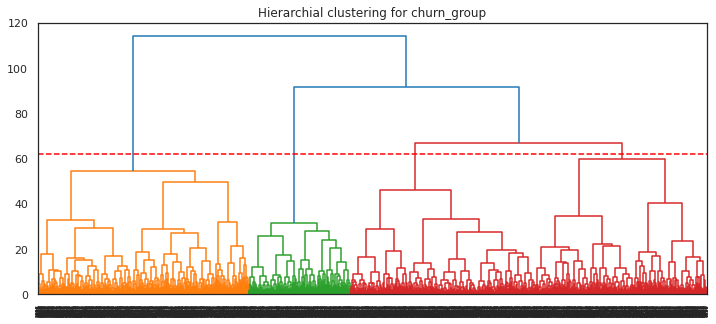

In [28]:
# стандартизируем данные
sc = StandardScaler()
churn_group_clust_st_2 = sc.fit_transform(churn_group_clust_2)

# строим дендрограмму
linked = linkage(churn_group_clust_st_2, method = 'ward')
linked

with sns.axes_style("white"): #задаём белый фон, так как раньше отменили стили
    plt.figure(figsize=(12, 5))  
    dendrogram(linked, orientation='top')
    plt.title('Hierarchial clustering for churn_group')

# проводим линию разделения на уровне 62
cl = 62
plt.axhline(y=cl, color='r', linestyle='--')

plt.show()

In [29]:
clusters = fcluster(linked, t=cl, criterion='distance')
print(f'Количество кластеров: {len(set(clusters))}')


Количество кластеров: 4


**Наблюдение**\
Мы видим более значимое разделе между группами признаков на уровне 3-4, чем в варианте с полным набором данных,\
и более слабое разделение на уровне 4-5


**Выберем количество кластеров, равное 4, как наиболее информативное.**

In [30]:
# задаём модель k_means с числом кластеров 4 и фиксируем значение random_state
# задаём количество начальных инициализаций n_init=10

km = KMeans(n_clusters=(len(set(clusters))), random_state=0, n_init=10)

# кластеры клиентов в новой переменной
gym_chur_cluster_4 = gym_churn.copy()
labels = km.fit_predict(churn_group_clust_st_2)
gym_chur_cluster_4['cluster'] = labels

# выводим средние значения признаков по кластерам
gym_churn_groupby_4 = gym_chur_cluster_4.groupby('cluster').mean().sort_values(by='churn', ascending = False)
display(gym_churn_groupby_4)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
2,0.486,1.000,0.346,0.232,0.900,2.009,0.339,28.191,131.250,1.918,2.435,1.250,1.013,0.513
3,0.496,0.000,0.482,0.072,0.909,2.827,0.220,28.580,136.344,2.662,2.933,1.683,1.505,0.420
1,0.556,0.978,0.344,0.230,0.936,2.657,0.474,30.114,160.541,2.449,4.973,2.859,2.859,0.069
0,0.512,0.986,0.782,0.592,0.880,10.654,0.555,30.000,161.271,9.734,4.754,1.982,1.972,0.031


In [31]:
# посмотрим размер кластеров
gym_chur_cluster_4['cluster'].value_counts()

2    1403
0    1114
1     900
3     583
Name: cluster, dtype: int64

In [32]:
# группируем и сортируем
cluster_analysis_4 = gym_chur_cluster_4.groupby('cluster').agg(
         {'churn': 'mean'}).sort_values(by='churn', ascending = False)

**Сравним кластеры, полученные на полных данных и на скорректированных.**

In [33]:
print ('Кластеризация по полным данным на 5 кластеров')
display(cluster_analysis)
print ('')
print ('Кластеризация по сокращенным данным на 4 кластера')
cluster_analysis_4

Кластеризация по полным данным на 5 кластеров


,churn
cluster,
3,0.514
2,0.444
1,0.268
4,0.068
0,0.028



Кластеризация по сокращенным данным на 4 кластера


,churn
cluster,
2,0.513
3,0.420
1,0.069
0,0.031


**Наблюдения**\
Кластеры стали более различимы по целевому показателю.\
Средний кластер  (имевшийся при разделении на 5) слился с двумя склонными к оттоку.

**Изучение средних значений показателей по кластерам**:\
У кластеров с высоким оттоком (в сравнении с более стабильными) наблюдаются более низкие показатели:
- promo_friends,
- contract_period и коррелирующий с ним month_to_end_contract (если сравнивать попарно стабильные с нестабильными)
- group_visits,
- avg_additional_charges_total
- lifetime
- month_to_end_contract
- avg_class_frequency_current_month и коррелирующий с ним avg_class_frequency_total.
- Показатель age у эти кластеров тоже ниже, и этот факт в долгосрочном планировании можнт быть важным.

Можно с уверенностью сказать, что **кластеры с высоким оттоком имеют более низкие показатели по тем признакам, которые связаны с активностью клиента**.


## Распределение признаков в кластерах (по вар. 2)

Строим гистограммы и располагаем их по структуре:\
строка - один признак, столбцы - кластеры, расположенные по мере убывания доли оттока слево направо.

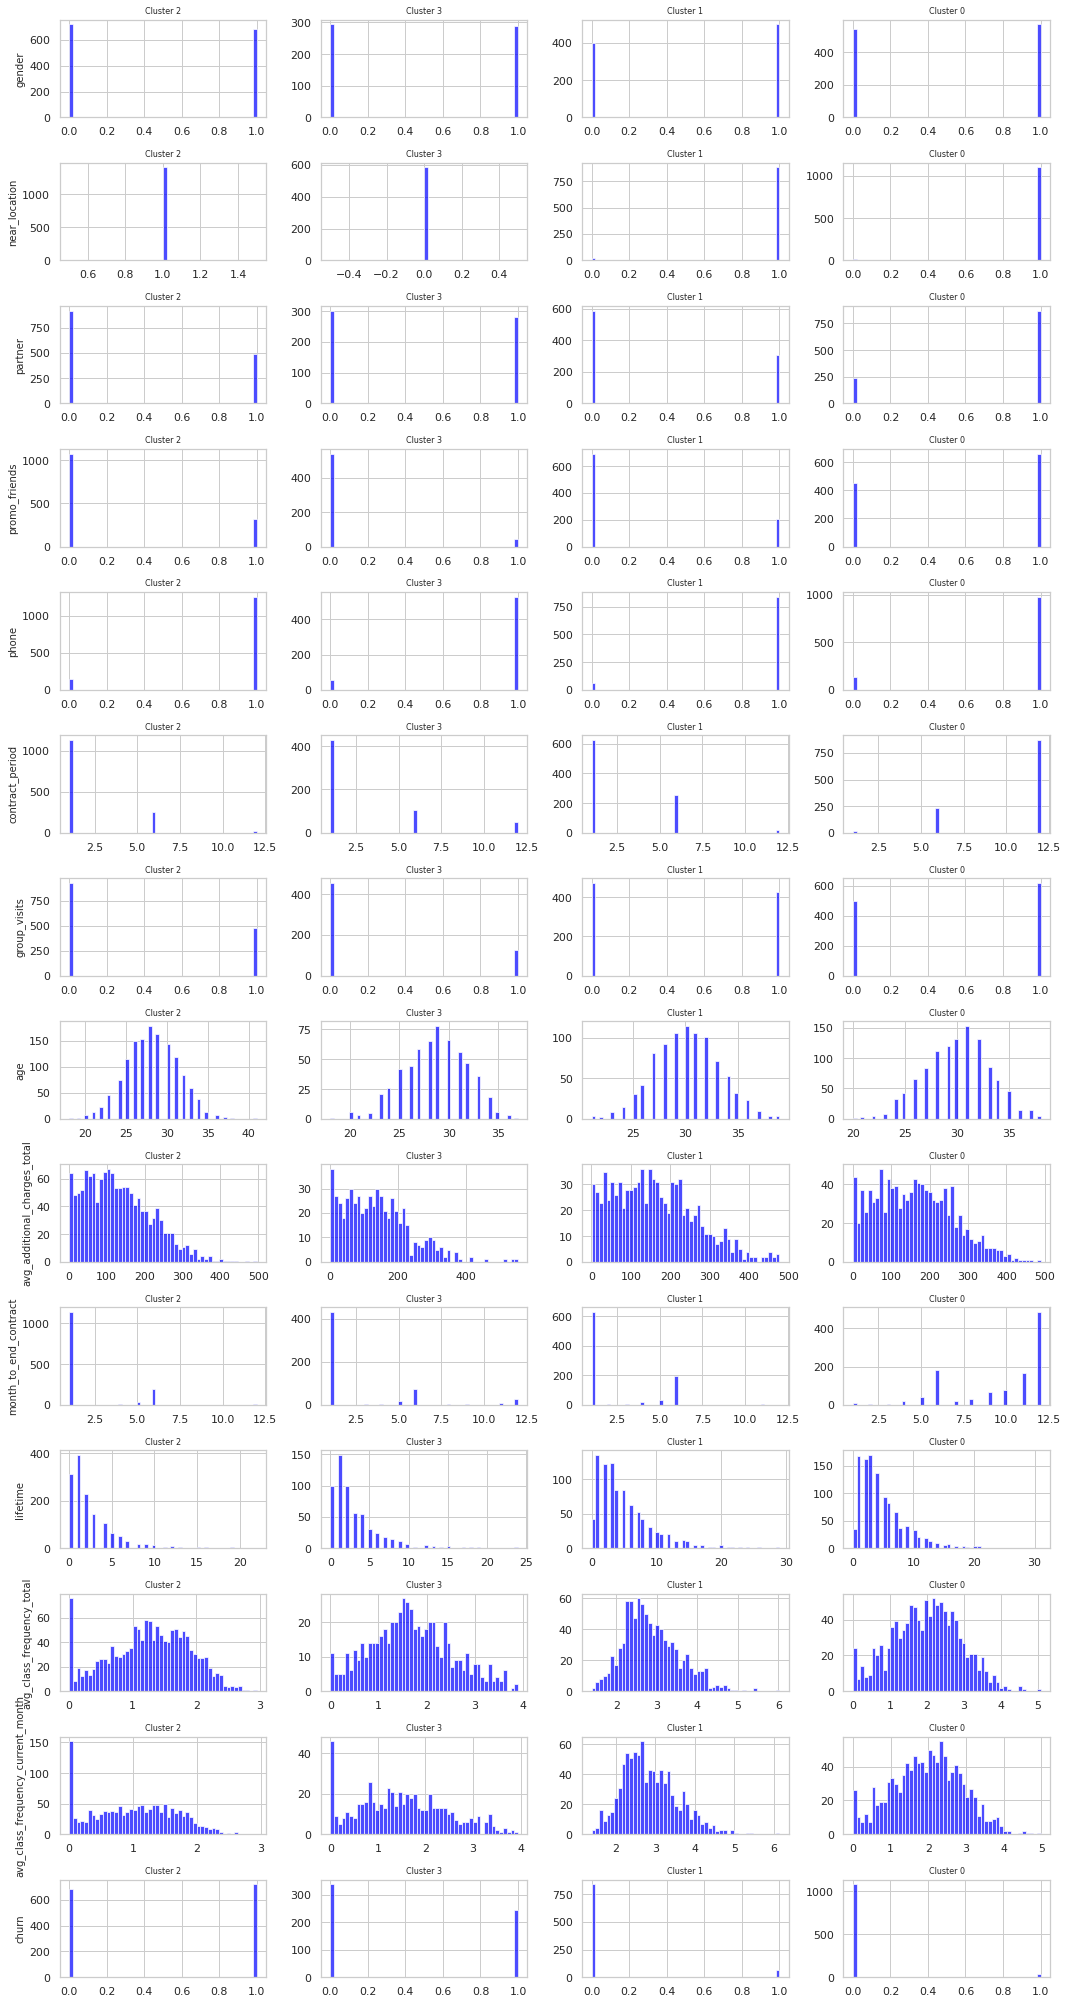

In [34]:
# список признаков, кроме 'cluster'
features = [col for col in gym_chur_cluster_4.columns if col != 'cluster']

# определяем количество кластеров и располагаем их В ПОРЯДКЕ УБЫВАНИЯ ДОЛИ ОТТОКА слева направо
#clusters = gym_chur_claster_4['cluster'].unique()
clusters = [2, 3, 1, 0]

# сетка графиков
num_features = len(features)
fig, axes = plt.subplots(nrows=num_features, ncols=len(clusters), figsize=(15, num_features * 2))

# перебираем все признаки
for row_idx, feature in enumerate(features):
    for col_idx, cluster in enumerate(clusters):
        # отбираем данные для каждого кластера
        cluster_data_4 = gym_chur_cluster_4[gym_chur_cluster_4['cluster'] == cluster]
        
        # строим гистограмму
        axes[row_idx, col_idx].hist(cluster_data_4[feature], bins=50, color='blue', alpha=0.7)
       
         # настраиваем подписи
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(f'{feature}', fontsize=10)  # Имя признака
        axes[row_idx, col_idx].set_title(f'Cluster {cluster}', fontsize=8)
        axes[row_idx, col_idx].set_xlabel('')

# настраиваем расстояние между графиками
plt.tight_layout()
plt.show()


## Объединим кластеры по признаку стабильности и сравним их

In [35]:
# добавляем новый столбец с High/Low в зависимости от номера кластера
gym_chur_cluster_4['churn_level'] = gym_chur_cluster_4['cluster'].apply(
    lambda x: 'Churn High' if x in [2, 3] else 'Churn Low')

# сключаем столбец 'cluster' из расчётов
columns_to_group_level = [col for col in gym_chur_cluster_4.columns if col != 'cluster']

# группируем по новому столбцу 'cluster_level' и считаем средние значения
churn_level_grouped_means_4 = gym_chur_cluster_4.groupby('churn_level')[columns_to_group_level].mean()

churn_level_grouped_means_4


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
churn_level,,,,,,,,,,,,,,
Churn High,0.489,0.706,0.386,0.185,0.902,2.249,0.304,28.305,132.745,2.136,2.582,1.377,1.158,0.486
Churn Low,0.531,0.982,0.586,0.430,0.905,7.080,0.519,30.051,160.945,6.479,4.852,2.374,2.368,0.048


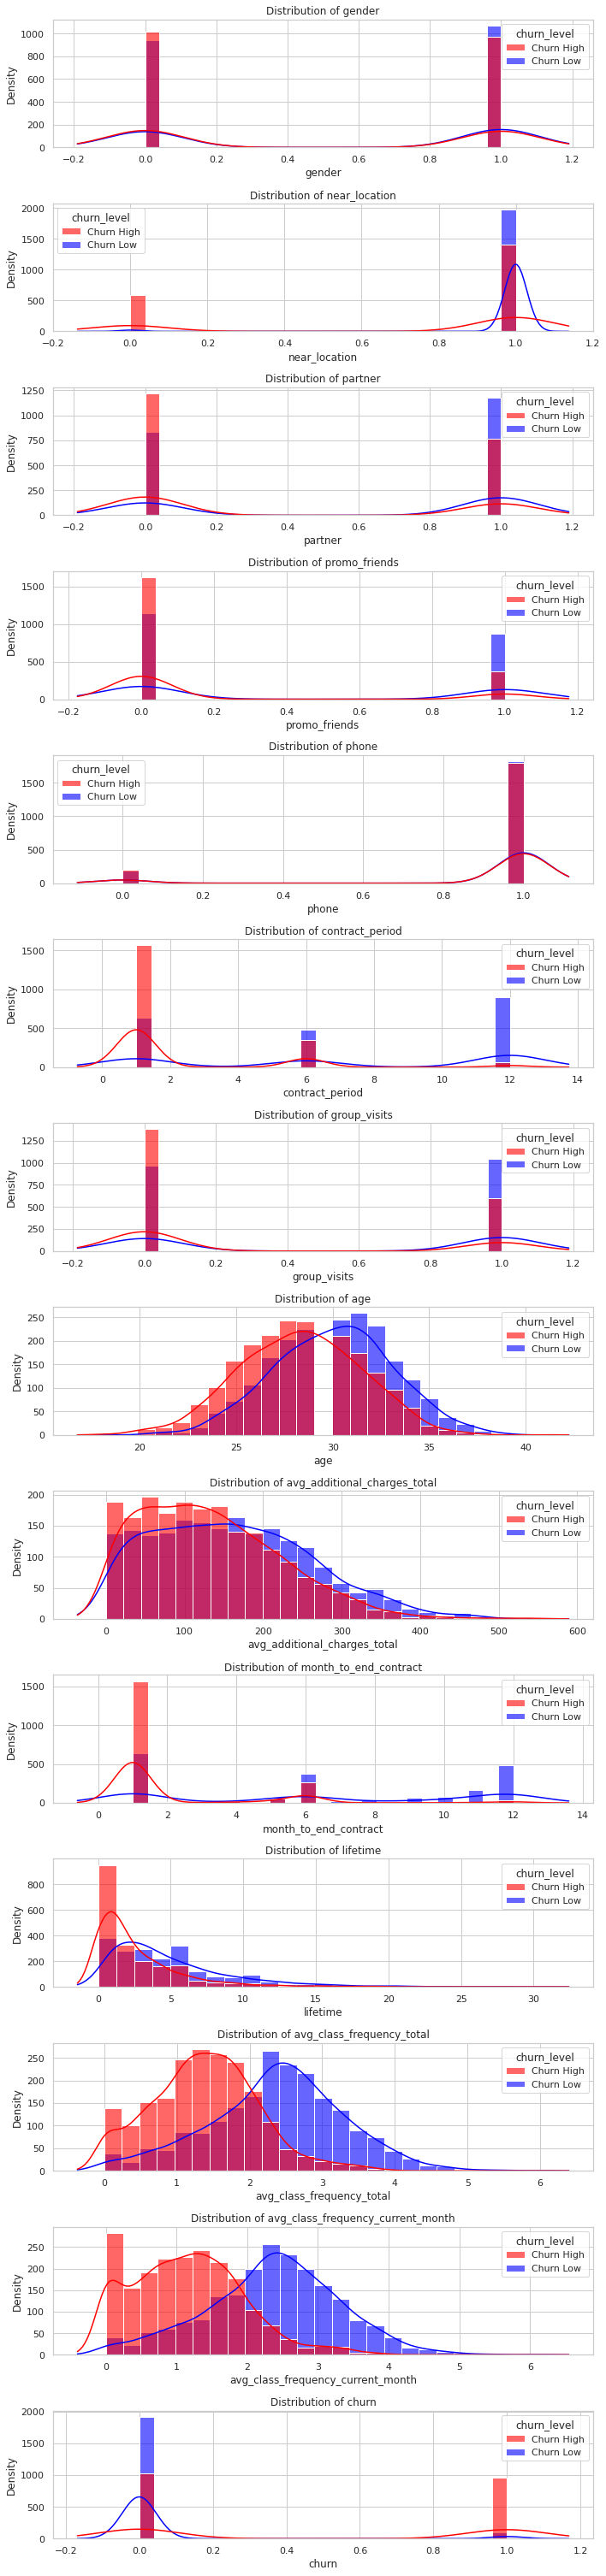

In [36]:
# список столбцов для построения гистограмм, исключая 'cluster'
columns_to_hist_churn_level = [col for col in churn_level_grouped_means_4.columns if col != 'cluster']

# создаем сетку графиков (по одному графику на признак)
num_features = len(columns_to_hist_churn_level)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, num_features * 3))

# стиль, palette=None отключает глобальные темы
sns.set_theme(style="whitegrid", palette=None)  

# перебираем признаки и строим совмещённые гистограммы
for idx, col in enumerate(columns_to_hist_churn_level):
    sns.histplot(
        data=gym_chur_cluster_4, x=col, hue='churn_level', bins=25, kde=True, ax=axes[idx],
        kde_kws={'bw_adjust': 1, 'cut': 2}, alpha=0.6, 
        palette={'Churn High': 'red', 'Churn Low': 'blue'})
    
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Density')

# Настраиваем расстояние между графиками
plt.tight_layout()
plt.show()


**Наблюдения**\
На основе таблицы средних значений признаков с разбивкой по 4-м кластерам и гистограммам признаков\
можно дать характеристики групп клиентов. Проименуем их через наиболее выраженные у них признаки. 

1) **Кластеры, имеющие низкую долю оттока - стабильные кластеры**.
   - А. Клиенты с долгосрочными контрактами (№ 0). Наименьшая доля оттока 0.031.     
        
   - Б. Клиенты с наибольшей частотой посещений (№ 1). Имеет малую долю оттока 0.069.
   
   В целом чаще посещают цетр, имеют более высокий возраст, больший лайфтайм, более длительные контракиы, проживают близко от фитнес-центра.
        
2) **Кластеры, имеющие высокую долю оттока - нестабильные кластеры**.
   - А. Пассивные клиенты, проживающие рядом с центром (№ 2). Имеет наибольшую долю оттока 0.513.
                
   - Б. Клиенты, проживающие не в районе фитнес-центра (№ 3). Имеет вторую по уровню долю оттока 0.420.
   
   В целом реже посёщают цетр, имеют меньший возраст, меньший лайфтайм, менее длительные контракиы, часть из них проживает далеко от фитнес-центра.
   
**Характеристики кластеров дадим в заключительной части - Выводя и рекомендации**.
                

<div style="background-color: #99FFFF; padding: 10px;">

# Выводы и рекомендации

## Группы клиентов

1) **Группы, имеющие низкую долю оттока - стабильные кластеры**.
   - А. **Клиенты с долгосрочными контрактами** (№ 0). Наименьшая доля оттока 3,1%.\
        Преобладают контракты 6-12 месяцев, практически нет на 1 месяц.\
        Больше половины (самая большая доля) пришли по партнёрским и маркетинговым  программам.\
        Наибольший срок до окончания контракиа 9.7 месяца.\
        Средняя посещаемость около 2 раз в месяц.
        
        
   - Б. **Клиенты с наибольшей частотой посещений** (№ 1). Имеет малую долю оттока 6,9%.\
        Отличие от первой группы - преобладание 1-месячных контрактов и отсутствие годовых.
        Меньше половины пришли по по партнёрским и маркетинговым  программам.\
        Срокдо оклнчания контракта 2,4 месяца.\
        Отличается от первой группы бОльшей частотой посещений.
        
        **Оба эти кластера**:\
        имеют наибольшие (практически одинаковые) расходы на доп. услуги,\
        клиенты живут рядом с фитнес-центром,\
        половина из них участвует в групповых занятиях,
        возраст клиентов выше, чем в нестабильных кластерах.
        
   
   
2) **Группы, имеющие высокую долю оттока - нестабильные кластеры**.
   - А. **Пассивные клиенты, проживающие рядом с центром**. (№ 2). Имеют наибольшую долю оттока 51,3%.\
        Все признаки активности ниже, чем в других кластерах, кроме участия в групповых занятиях.\
        Преобладают 1-месячные контракты.\
        Наиболее низкий возраст,\
        проживают рядом с фитнес-центром.\
        Имеют наименьший срок до оклнчания контракта 1,9 месяца.
        
        
        
   - Б. **Клиенты, проживающие НЕ в районе фитнес-центра** (№ 3) Имеет вторую по уровню долю оттока 42%.\
        Признаки, связанные с активностью, выше, чем в Пассивном кластере,\
        а по частоте посещений приближаются к самому стабильному кластеру.\
        Половина клиентов пришла по партнёрским программам.\
        Самая низкая доля прищедших по акции.\
        Срок до окончания контракта 2,7 месяца, что даже больше, чем у кластера "Наибольшая частота посещений"
        


## Меры по снижению оттока

Имеются 2 критические группы:
- Пассивные клиенты, проживаюшие раядом с фитнес-центром,
- Клиенты, проживающие далеко от фитнес центра.

**Первая группа** отличается (кроме низкой активности), преобладанием коротких контрактов и более низким средним возрастом. Возможные меры по повышению заинтересованности в приобретении более долгих контрактов.\
На пример, предоставив таким клиентам скидки в зависимости от количества посещений за первый месяц (также можно связать с количеством групповых занятий).

**Вторая группа**. Кроме дальнего проживангия эта группа отличается практически нулевой долей пришедщих с друзьями и минимальным показателем групповых занятий. Но по другим характеристикам эти клиенты приближаются к одной из стабильных групп.\
Таким образом, видна заинтересованность этих клиентов в занятиях, но удалённое местожительство и отсутсвие друзей-соратников мешает им и приводит от оттоку.\
Половина из них пришла по партнёрским программам, но удалённость от жилья, видимо, является препятствием для посещения центра с коллегами по работе.\
Можно предложиь таким клиентам лучшие условия по акции "Приведи друга", семейные программы. льготные "Программы выходного дня".

## Рекомендации по работе с клиентами

Организовать систему мониторинга удовлетворённости клиента во всех точках его взаимодействия с центром.\
Выявлять слабые места, вызывающие дискомфорт клиента. Анкетирование и интервью - хорошие инсьтрументы для этого.